In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [26]:
# Fetch historical price data from Yahoo Finance API
def fetch_historical_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    # Calculate indicators: MA50, MA200, RSI, MACD, Signal Line
    data['MA50'] = data['Close'].rolling(window=50).mean()
    data['MA200'] = data['Close'].rolling(window=200).mean()
    data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['RSI'] = calculate_rsi(data['Close'])
    data['SAR'] = calculate_parabolic_sar(data['High'], data['Low'])
    data['ATR'] = calculate_atr(data['High'], data['Low'], data['Close'])
    return data

def calculate_parabolic_sar(high, low, acceleration=0.02, max_acceleration=0.2):
    sar = high.copy()
    sar.iloc[0] = low.iloc[0]
    ep = high.iloc[0]  # Extreme Point
    af = acceleration  # Acceleration Factor
    bull = True
    
    for i in range(1, len(high)):
        if bull:
            sar.iloc[i] = sar.iloc[i-1] + af * (ep - sar.iloc[i-1])
            if high.iloc[i] > ep:
                ep = high.iloc[i]
                af = min(af + acceleration, max_acceleration)
            if sar.iloc[i] > low.iloc[i]:
                bull = False
                sar.iloc[i] = ep
                af = acceleration
                ep = low.iloc[i]
        else:
            sar.iloc[i] = sar.iloc[i-1] + af * (ep - sar.iloc[i-1])
            if low.iloc[i] < ep:
                ep = low.iloc[i]
                af = min(af + acceleration, max_acceleration)
            if sar.iloc[i] < high.iloc[i]:
                bull = True
                sar.iloc[i] = ep
                af = acceleration
                ep = high.iloc[i]

    return sar

def calculate_atr(high, low, close, period=14):
    high_low = high - low
    high_close = np.abs(high - close.shift())
    low_close = np.abs(low - close.shift())

    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    atr = true_range.rolling(window=period).mean()
    
    return atr

# Function to calculate RSI
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Define your strategy conditions
def strategy(data):
    # Identify Buy/Sell Signals
    buy_signals = [np.nan]  # Starting with NaN to align with the DataFrame's index
    sell_signals = [np.nan]  # Starting with NaN
    # Calculate Parabolic SAR and ATR
    for i in range(1, len(data)):
        # Buy signal: If price is above SAR
        if data['Close'].iloc[i] > data['SAR'].iloc[i] and data['RSI'].iloc[i] < 30:
            buy_signals.append(data['Close'].iloc[i])
            sell_signals.append(np.nan)
        # Sell signal: If price is below SAR
        elif data['Close'].iloc[i] < data['SAR'].iloc[i] and data['RSI'].iloc[i] > 70:
            buy_signals.append(np.nan)
            sell_signals.append(data['Close'].iloc[i])
        else:
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)

    data['Buy_Signal'] = buy_signals
    data['Sell_Signal'] = sell_signals

    # Calculate strategy returns
    data['Position'] = np.where(~np.isnan(data['Buy_Signal']), 1, 0)
    data['Strategy_Return'] = data['Close'].pct_change() * data['Position'].shift(1)
    return data

def portfolio_strategy(data, portfolio, ticker, stop_loss_percent=-10, take_profit_percent=13):
    data = strategy(data)
    bought_price = None
    for i in range(1, len(data)):
        current_price = data['Close'].iloc[i]
        price_change_percent = ((current_price - bought_price) / bought_price) * 100 if bought_price else None

        # Sell if stop loss or take profit conditions are met
        if portfolio['holdings'][ticker] > 0 and (price_change_percent <= stop_loss_percent or price_change_percent >= take_profit_percent):
            portfolio['cash'] += portfolio['holdings'][ticker] * current_price
            portfolio['holdings'][ticker] = 0
            bought_price = None
        # Regular buy/sell signals
        elif data['Buy_Signal'].iloc[i] and portfolio['cash'] >= current_price:
            shares_to_buy = portfolio['cash'] // current_price
            portfolio['cash'] -= shares_to_buy * current_price
            portfolio['holdings'][ticker] += shares_to_buy
            bought_price = current_price
        elif data['Sell_Signal'].iloc[i] and portfolio['holdings'][ticker] > 0:
            portfolio['cash'] += portfolio['holdings'][ticker] * current_price
            portfolio['holdings'][ticker] = 0
            bought_price = None

    return portfolio, data

def portfolio(portfolio_tickers, start_date, end_date): 
    # Fetch and apply strategy to each stock in the portfolio
    portfolio_data = {}
    final_prices = {}
    portfolio = {'cash': 100000, 'holdings': {ticker: 0 for ticker in portfolio_tickers}}
    for ticker in portfolio_tickers:
        stock_data = fetch_historical_data(ticker, start_date, end_date)
        portfolio, stock_data = portfolio_strategy(stock_data, portfolio, ticker)
        portfolio_data[ticker] = stock_data
        final_prices[ticker] = stock_data['Close'].iloc[-1]
        
    # Combine the individual strategy returns into a portfolio
    portfolio_return = pd.DataFrame()
    for ticker, data in portfolio_data.items():
        portfolio_return[ticker] = data['Strategy_Return']

    # Assuming equal weighting for simplicity
    portfolio_return['Total'] = portfolio_return.mean(axis=1)

    # Calculate cumulative returns
    portfolio_return['Cumulative'] = (1 + portfolio_return['Total']).cumprod()
    # Calculate total value of stock holdings
    total_stock_value = sum(portfolio['holdings'][ticker] * final_prices[ticker] for ticker in portfolio_tickers)

    # Calculate total portfolio value (cash + stock holdings)
    total_portfolio_value = portfolio['cash'] + total_stock_value

    # Display final portfolio values
    print("Final Cash:", portfolio['cash'])
    print("Total Stock Value:", total_stock_value)
    print("Total Portfolio Value:", total_portfolio_value)
    print(portfolio_return)
    return portfolio_return

# Function to calculate total portfolio value
def calculate_portfolio_value(portfolio):
    total_value = portfolio['cash']
    for ticker, shares in portfolio['holdings'].items():
        data = yf.download(ticker)
        total_value += shares * ticker['Close']
    return total_value

[*********************100%%**********************]  1 of 1 completed
Date
2022-01-03   NaN
2022-01-04   NaN
2022-01-05   NaN
2022-01-06   NaN
2022-01-07   NaN
              ..
2024-02-29   NaN
2024-03-01   NaN
2024-03-04   NaN
2024-03-05   NaN
2024-03-06   NaN
Name: Sell_Signal, Length: 546, dtype: float64


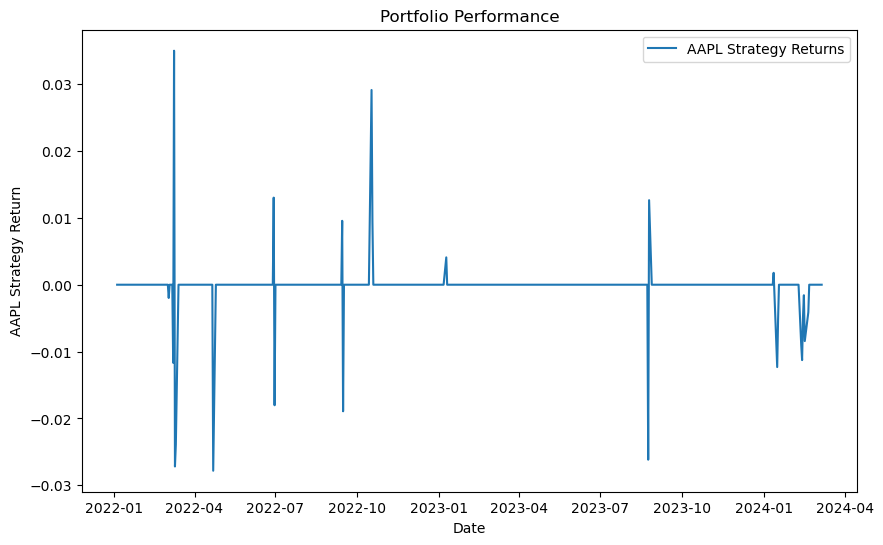

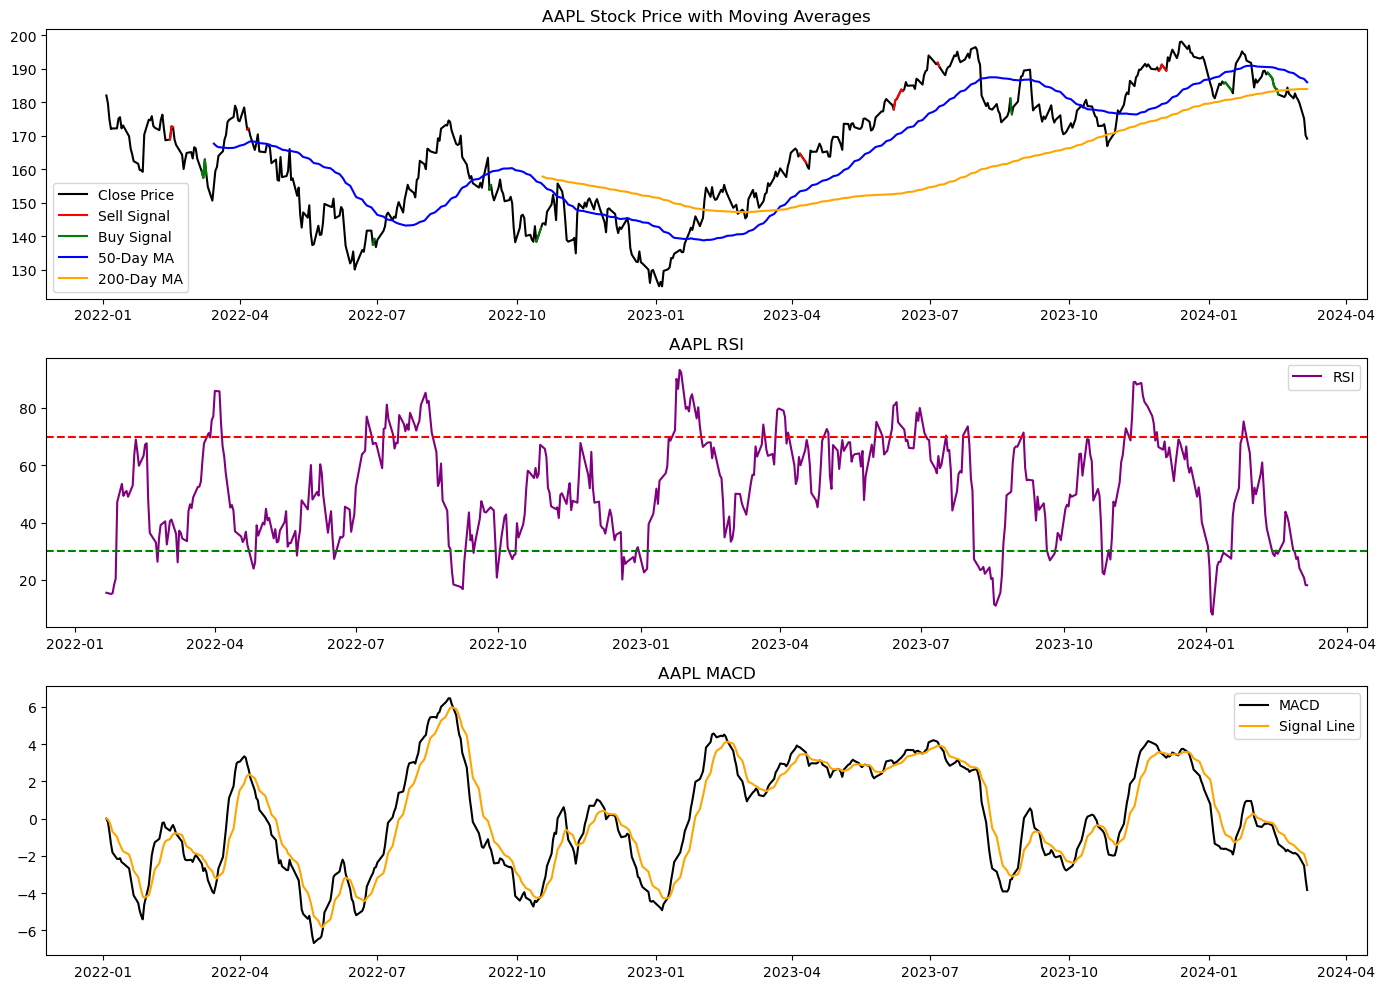

In [27]:
# Define the stock symbol, start date, and end date
symbol = 'AAPL'  # Replace with your desired stock symbol
start_date = '2022-01-01'
end_date = '2024-03-07'
data = fetch_historical_data(symbol, start_date, end_date)
strategy_data = strategy(data)
print(data['Sell_Signal'])
plt.figure(figsize=(10, 6))
plt.plot(strategy_data['Strategy_Return'], label='AAPL Strategy Returns')
plt.title('Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('AAPL Strategy Return')
plt.legend()
plt.show()

# Plotting
plt.figure(figsize=(14, 10))

# Plot Closing Price, MA50, and MA200
plt.subplot(311)
plt.plot(data['Close'], label='Close Price', color='black')
plt.plot(data['Sell_Signal'], label='Sell Signal', color='red')
plt.plot(data['Buy_Signal'], label='Buy Signal', color='green')
plt.plot(data['MA50'], label='50-Day MA', color='blue')
plt.plot(data['MA200'], label='200-Day MA', color='orange')

plt.title('AAPL Stock Price with Moving Averages')
plt.legend()

# Plot RSI
plt.subplot(312)
plt.plot(data['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title('AAPL RSI')
plt.legend()

# Plot MACD and Signal Line
plt.subplot(313)
plt.plot(data['MACD'], label='MACD', color='black')
plt.plot(data['Signal_Line'], label='Signal Line', color='orange')
plt.title('AAPL MACD')
plt.legend()

plt.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

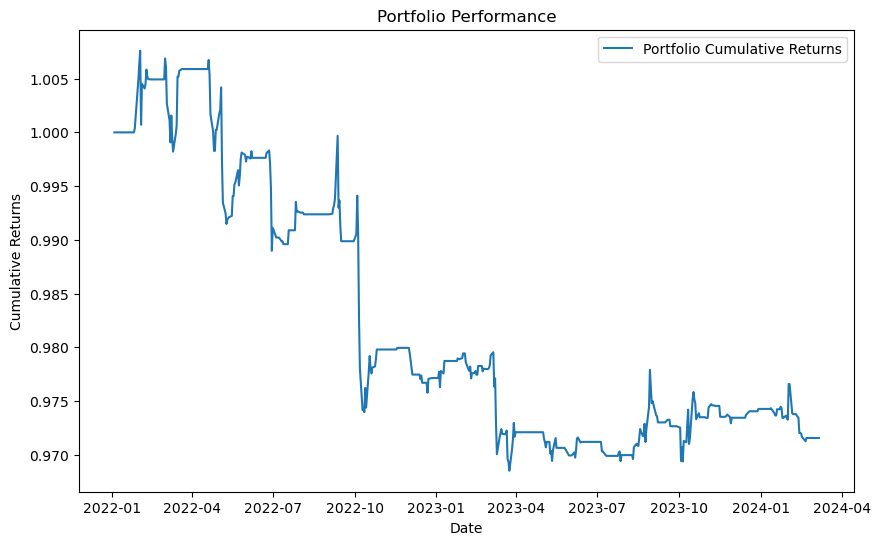

In [28]:
# Define your portfolio
portfolio_tickers = ['SPYG', 'SPEU', 'VLVLY', 'BOTZ', 'RITM',
    "MSFT", "AAPL", "PG", "KO", "JNJ", "PFE",
    "XLK", "IBB", "ICLN", "JPM", "BAC", "XOM", "CVX",
    "EEM", "VGK", "NEE", "DUK", "VZ", "ZBRA", "SAM"
]

start_date = '2022-01-01'
end_date = '2024-3-07'

portfolio_return = portfolio(portfolio_tickers, start_date, end_date)

# Portfolio Metrics
total_return = portfolio_return['Cumulative'].iloc[-1] - 1
annualized_return = portfolio_return['Total'].mean() * 252
annualized_volatility = portfolio_return['Total'].std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility

print(f"Total Return: {total_return:.2f}")
print(f"Annualized Return: {annualized_return:.2f}")
print(f"Annualized Volatility: {annualized_volatility:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Plotting the portfolio performance
plt.figure(figsize=(10, 6))
plt.plot(portfolio_return['Cumulative'], label='Portfolio Cumulative Returns')
plt.title('Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

In [ ]:
portfolio_return